In this notebook al the data of jump fast is read and processed. This includes every variation in measuring the movement. The shuffeling of the dataset was not done for constructing the CNN datasets.

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

## help functions

In [2]:
raw = True
teller = 0
freq = 0

In [3]:
def sampling_freq(df):
    start = df['time'].iloc[0]
    sum_samples = 0
    index = 0
    while  (start + pd.to_timedelta(1, unit='s')) < df['time'].iloc[-1]:
        end =  start + pd.to_timedelta(1, unit='s')
        sum_samples += df[(df['time'] >= start) & (df['time'] < end)].shape[0]
        start += pd.to_timedelta(1, unit='s')
        index += 1
    return sum_samples/index

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, type_, p, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    data['type'] = type_
    data['proefpersoon'] = p
    
    return data

#feature extraction
def get_mean_window(df):
    return df.mean()

def get_min_window(df):
    return df.min()

def get_max_window(df):
    return df.max()

def get_std_window(df):
    return df.std()

def get_med_window(df):
    return df.median()

#measure of activity level (m/s²)
def get_signal_magnitude_area(df):
        sum = 0
        for i in range(0, len(df)):
            sum += (abs(df['x'].iloc[i]) + abs(df['y'].iloc[i]) + abs(df['z'].iloc[i]))
        return sum /len(df)

#degree of movement intensity (m/s²)
def get_signal_magnitude_vector(df):
    sum = 0
    for i in range(0, len(df)):
        sum += math.sqrt(df['x'].iloc[i] * df['x'].iloc[i] + df['y'].iloc[i] * df['y'].iloc[i] + df['z'].iloc[i] * df['z'].iloc[i])
    return sum

#average angle (radian) between accelerometer vector and x as (parallel with arm)
def get_tilt_angle(df):
    df_cos = pd.DataFrame(columns=["tilt_ang"])
    df_dot = df['x']
    for i in range(0, len(df)):
        s = pd.Series({"tilt_ang" : (df_dot.iloc[i])/(math.sqrt(df['x'].iloc[i]*df['x'].iloc[i] + df['y'].iloc[i]*df['y'].iloc[i] + df['z'].iloc[i]*df['z'].iloc[i]))})
        df_cos=df_cos.append(s, ignore_index=True)
    df_angle = np.arccos(df_cos)
    return df_angle.mean()['tilt_ang']

def get_power_spectral_density(df):
    df_psd = np.abs(df)**2
    return df_psd.sum()

#generate windows with 50% overlap
def windows(df, time, overlap):
    start = df.iloc[0]
    while  (start + pd.to_timedelta(time, unit='s')) < df.iloc[-1]:
        yield start, (start + pd.to_timedelta(time, unit='s'))
        if overlap:
            start += pd.to_timedelta(time/2, unit='s')
        else:
            start += pd.to_timedelta(time, unit='s')
    #last samples 
    yield (df.iloc[-1] - pd.to_timedelta(time, unit='s')), df.iloc[-1]
        
def feature_extraction_segmentation(data, window, overlap):
    column_names = ["x_mean", "y_mean", "z_mean", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max",
                "x_std", "y_std", "z_std", "x_med", "y_med", "z_med", "activity"]
    df = pd.DataFrame(columns = column_names)

    for (start, end) in windows(data['time'], window, overlap):
        vw1 = data['time'] >= start
        vw2 = data['time'] < end
        mean = get_mean_window(data[vw1 & vw2])
        min = get_min_window(data[vw1 & vw2])
        max = get_max_window(data[vw1 & vw2])
        std = get_std_window(data[vw1 & vw2])
        med = get_med_window(data[vw1 & vw2])
        sma = get_signal_magnitude_area(data[vw1 & vw2])
        smv = get_signal_magnitude_vector(data[vw1 & vw2])
        tilt = get_tilt_angle(data[vw1 & vw2])
        #fourrier transform
        t_x = data[vw1 & vw2][['time','x']].set_index('time')
        t_y = data[vw1 & vw2][['time','y']].set_index('time')
        t_z = data[vw1 & vw2][['time', 'z']].set_index('time')

        df_f = pd.DataFrame(columns=['f', 'x_f', 'y_f', 'z_f'])

        sampling_rate = 52

        df_f['x_f'] = FFT.fft(t_x).ravel()
        df_f['y_f'] = FFT.fft(t_y).ravel()
        df_f['z_f'] = FFT.fft(t_z).ravel()
        df_f['f'] = FFT.fftfreq(len(df_f['x_f'])) * sampling_rate

        psd = get_power_spectral_density(df_f)

        df = df.append(pd.Series({'x_mean': mean['x'], 'y_mean': mean['y'], 'z_mean': mean['z'], "x_min" : min['x'],
                              "y_min" : min['y'], "z_min" : min['z'], "x_max" : max['x'], "y_max" : max['y'], "z_max" : max['z'],
                              "x_std" : std['x'], "y_std" : std['y'], "z_std" : std['z'], "x_med" : med['x'], "y_med" : med['y'], "z_med" : med['z'],
                              "sma" : sma, "smv" : smv, "tilt" : tilt, "x_psd" : psd['x_f'], "y_psd" : psd['y_f'], "z_psd" : psd['z_f']
                              , "activity" : data['activity'].iloc[0]}), ignore_index=True) # "x_entropy" : entropy[0], "y_entropy" : entropy[1], "z_entropy" : entropy[2],
    return df

column_names_org = ['time', 'x', 'y', 'z']

# <font color='green' >PROEFPERSOON 1

## jump_fast

In [5]:
jump_fast_left_forward_1 = []
jump_fast_right_forward_1 = []
jump_fast_left_backwards_1 = []
jump_fast_right_backwards_1 = []

#### jump_fast_left_forward

In [4]:
jump_fast_left_forward1 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_left_forward-tim.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_left_forward2 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_left_forward_tim1.csv", sep=';', header=0, skipinitialspace=True)

jump_fast_left_forward1 = preprocess(jump_fast_left_forward1, "jump_fast","left_forward", 1, 3,5)
jump_fast_left_forward2 = preprocess(jump_fast_left_forward2, "jump_fast","left_forward", 1)

jump_fast_left_forward_1 = [jump_fast_left_forward1, jump_fast_left_forward2]

<IPython.core.display.Javascript object>


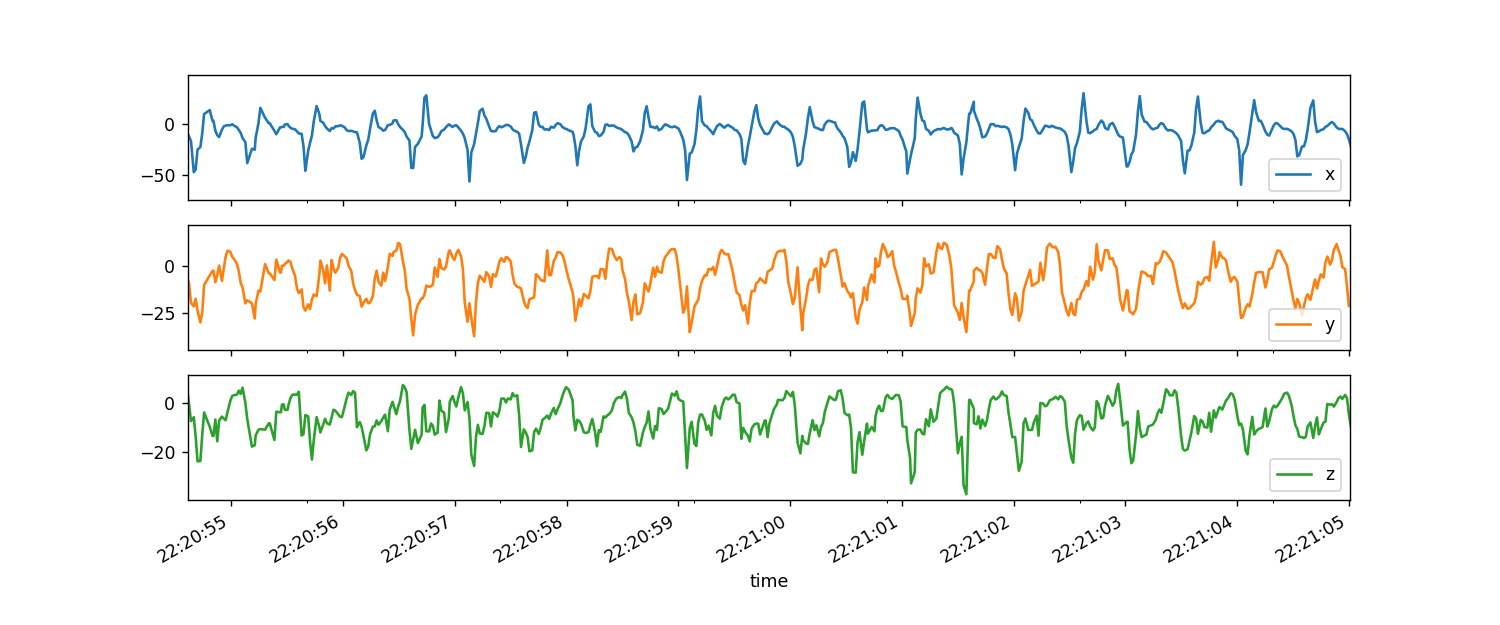

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001408383D5C8>,
      dtype=object)

In [5]:
jump_fast_left_forward2.drop("proefpersoon", axis=1).plot(x='time', subplots=True)

In [7]:
for df in jump_fast_left_forward_1:
    f = sampling_freq(df)
    freq += f

#### jump_fast_right_forward

In [8]:
jump_fast_right = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_tim(meting2).csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right2 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_right_forward_tim.csv", sep=';', header=0, skipinitialspace=True)

jump_fast_right = preprocess(jump_fast_right, "jump_fast","right_forward", 1)
jump_fast_right2 = preprocess(jump_fast_right2, "jump_fast","right_forward", 1)

jump_fast_right_forward_1 = [jump_fast_right, jump_fast_right2]

<IPython.core.display.Javascript object>


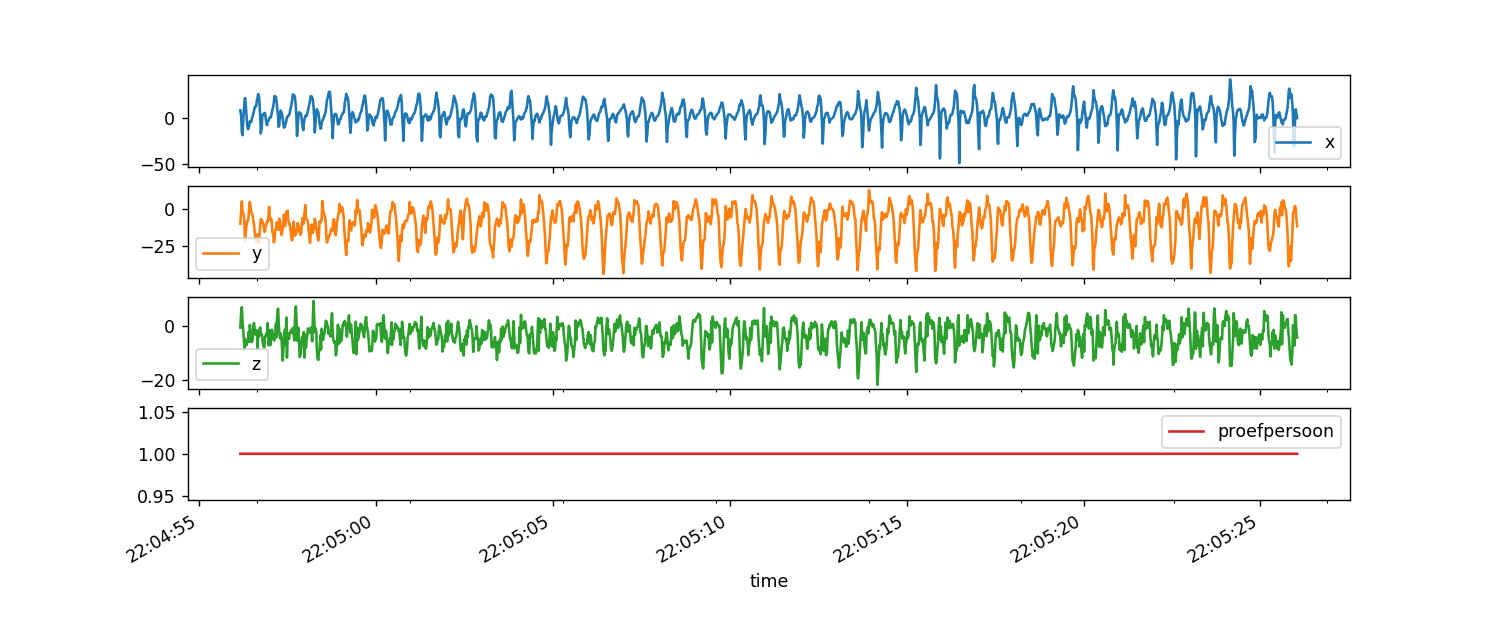

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000211ABC0C348>,
      dtype=object)

In [9]:
jump_fast_right2.plot(x='time', subplots=True)

In [10]:
for df in jump_fast_right_forward_1:
    f = sampling_freq(df)
    freq += f

#### jump_fast_left_backwards

In [11]:
jump_fast_left_backwards1 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_left_backwards_tim1.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_left_backwards2 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_left_backwards_tim2.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_left_backwards3 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_left_backwards_tim3.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_left_backwards4 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_left_backwards_tim(2).csv", sep=';', header=0, skipinitialspace=True)
jump_fast_left_backwards5 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_left_backwards_tim(1).csv", sep=';', header=0, skipinitialspace=True)

jump_fast_left_backwards1 = preprocess(jump_fast_left_backwards1, "jump_fast","left_backwards", 1)
jump_fast_left_backwards2 = preprocess(jump_fast_left_backwards2, "jump_fast","left_backwards", 1)
jump_fast_left_backwards3 = preprocess(jump_fast_left_backwards3, "jump_fast","left_backwards", 1)
jump_fast_left_backwards4 = preprocess(jump_fast_left_backwards4, "jump_fast","left_backwards", 1)
jump_fast_left_backwards5 = preprocess(jump_fast_left_backwards5, "jump_fast","left_backwards", 1)

jump_fast_left_backwards_1 = [jump_fast_left_backwards1, jump_fast_left_backwards2, jump_fast_left_backwards3, jump_fast_left_backwards4, jump_fast_left_backwards5]

In [12]:
for df in jump_fast_left_backwards_1:
    f = sampling_freq(df)
    freq += f

#### jump_fast_right_backwards

In [13]:
jump_fast_right_backwards1 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_right_backwards_tim.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_backwards2 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_right_backwards_tim2.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_backwards3 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_right_backwards_tim3.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_backwards4 = pd.read_csv(r"..\data\jump_fast\proefpersoon1\jump_fast_right_backwards_tim(1).csv", sep=';', header=0, skipinitialspace=True)

jump_fast_right_backwards1 = preprocess(jump_fast_right_backwards1, "jump_fast","right_backwards", 1)
jump_fast_right_backwards2 = preprocess(jump_fast_right_backwards2, "jump_fast","right_backwards", 1)
jump_fast_right_backwards3 = preprocess(jump_fast_right_backwards3, "jump_fast","right_backwards", 1, 3, 4)
jump_fast_right_backwards4 = preprocess(jump_fast_right_backwards4, "jump_fast","right_backwards", 1)

jump_fast_right_backwards_1 = [jump_fast_right_backwards1, jump_fast_right_backwards2, jump_fast_right_backwards3, jump_fast_right_backwards4]

In [14]:
for df in jump_fast_right_backwards_1:
    f = sampling_freq(df)
    freq += f

### SEGMENTATION

In [15]:
if(not raw):
    #segmentation + feature extraction
    for i in range(0, len(jump_fast_left_forward_1)):
        jump_fast_left_forward_1[i] =  feature_extraction_segmentation(jump_fast_left_forward_1[i],1, True)

    for i in range(0, len(jump_fast_right_forward_1)):
        jump_fast_right_forward_1[i] =  feature_extraction_segmentation(jump_fast_right_forward_1[i],1, True)
    
    for i in range(0, len(jump_fast_left_backwards_1)):
        jump_fast_left_backwards_1[i] =  feature_extraction_segmentation(jump_fast_left_backwards_1[i],1, True)

    for i in range(0, len(jump_fast_right_backwards_1)):
        jump_fast_right_backwards_1[i] =  feature_extraction_segmentation(jump_fast_right_backwards_1[i],1, True)

In [16]:
jump_fast_right_backwards_1 = pd.concat(jump_fast_right_backwards_1, ignore_index=True)
jump_fast_right_backwards_1.shape

(3782, 7)

In [17]:
jump_fast_left_forward_1 = pd.concat(jump_fast_left_forward_1, ignore_index=True)
jump_fast_left_forward_1.shape

(2504, 7)

In [18]:
jump_fast_right_forward_1 = pd.concat(jump_fast_right_forward_1, ignore_index=True)
jump_fast_right_forward_1.shape

(3074, 7)

In [19]:
jump_fast_left_backwards_1 = pd.concat(jump_fast_left_backwards_1, ignore_index=True)
jump_fast_left_backwards_1.shape

(3674, 7)

### SHUFFLE - BALANCING

In [20]:
shape = np.min([
    jump_fast_right_backwards_1.shape[0], 
    jump_fast_left_forward_1.shape[0], 
    jump_fast_right_forward_1.shape[0], 
    jump_fast_left_backwards_1.shape[0]])

#### shuffle

In [21]:
''' 
jump_fast_right_backwards_1 = shuffle(jump_fast_right_backwards_1).head(shape).copy()
jump_fast_left_forward_1 = shuffle(jump_fast_left_forward_1).head(shape).copy()
jump_fast_right_forward_1 = shuffle(jump_fast_right_forward_1).head(shape).copy()
jump_fast_left_backwards_1 = shuffle(jump_fast_left_backwards_1).head(shape).copy()'''

' \njump_fast_right_backwards_1 = shuffle(jump_fast_right_backwards_1).head(shape).copy()\njump_fast_left_forward_1 = shuffle(jump_fast_left_forward_1).head(shape).copy()\njump_fast_right_forward_1 = shuffle(jump_fast_right_forward_1).head(shape).copy()\njump_fast_left_backwards_1 = shuffle(jump_fast_left_backwards_1).head(shape).copy()'

#### no shuffle

In [22]:
''' 
jump_fast_right_backwards_1 = jump_fast_right_backwards_1.head(shape).copy()
jump_fast_left_forward_1 = jump_fast_left_forward_1.head(shape).copy()
jump_fast_right_forward_1 = jump_fast_right_forward_1.head(shape).copy()
jump_fast_left_backwards_1 = jump_fast_left_backwards_1.head(shape).copy()'''

' \njump_fast_right_backwards_1 = jump_fast_right_backwards_1.head(shape).copy()\njump_fast_left_forward_1 = jump_fast_left_forward_1.head(shape).copy()\njump_fast_right_forward_1 = jump_fast_right_forward_1.head(shape).copy()\njump_fast_left_backwards_1 = jump_fast_left_backwards_1.head(shape).copy()'

# <font color='green' >PROEFPERSOON 2

## jump_fast

In [24]:
jump_fast_left_forward_2 = []
jump_fast_right_forward_2 = []
jump_fast_left_backwards_2 = []
jump_fast_right_backwards_2 = []

#### jump_fast_left_forward

In [25]:
jump_fast = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast.csv", sep=';', header=0, skipinitialspace=True)
jump_fast2 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast (meting2).csv", sep=';', header=0, skipinitialspace=True)
jump_fast3 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast_left_forward1.csv", sep=';', header=0, skipinitialspace=True)

jump_fast = preprocess(jump_fast, "jump_fast","left_forward", 2)
jump_fast2 = preprocess(jump_fast2, "jump_fast","left_forward", 2)
jump_fast3 = preprocess(jump_fast3, "jump_fast","left_forward", 2)

jump_fast_left_forward_2 = [jump_fast, jump_fast2, jump_fast3]

In [26]:
for df in jump_fast_left_forward_2:
    f = sampling_freq(df)
    freq += f

#### jump_fast_right_forward

In [28]:
jump_fast_right_forward1 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast_right_forward1.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_forward2 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast_right_forward2.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_forward3 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast_right_forward1(2).csv", sep=';', header=0, skipinitialspace=True)

jump_fast_right_forward1 = preprocess(jump_fast_right_forward1, "jump_fast","right_forward", 2)
jump_fast_right_forward2 = preprocess(jump_fast_right_forward2, "jump_fast","right_forward", 2, 3, 5)
jump_fast_right_forward3 = preprocess(jump_fast_right_forward3, "jump_fast","right_forward", 2)

jump_fast_right_forward_2 = [jump_fast_right_forward1, jump_fast_right_forward2, jump_fast_right_forward3]

<IPython.core.display.Javascript object>


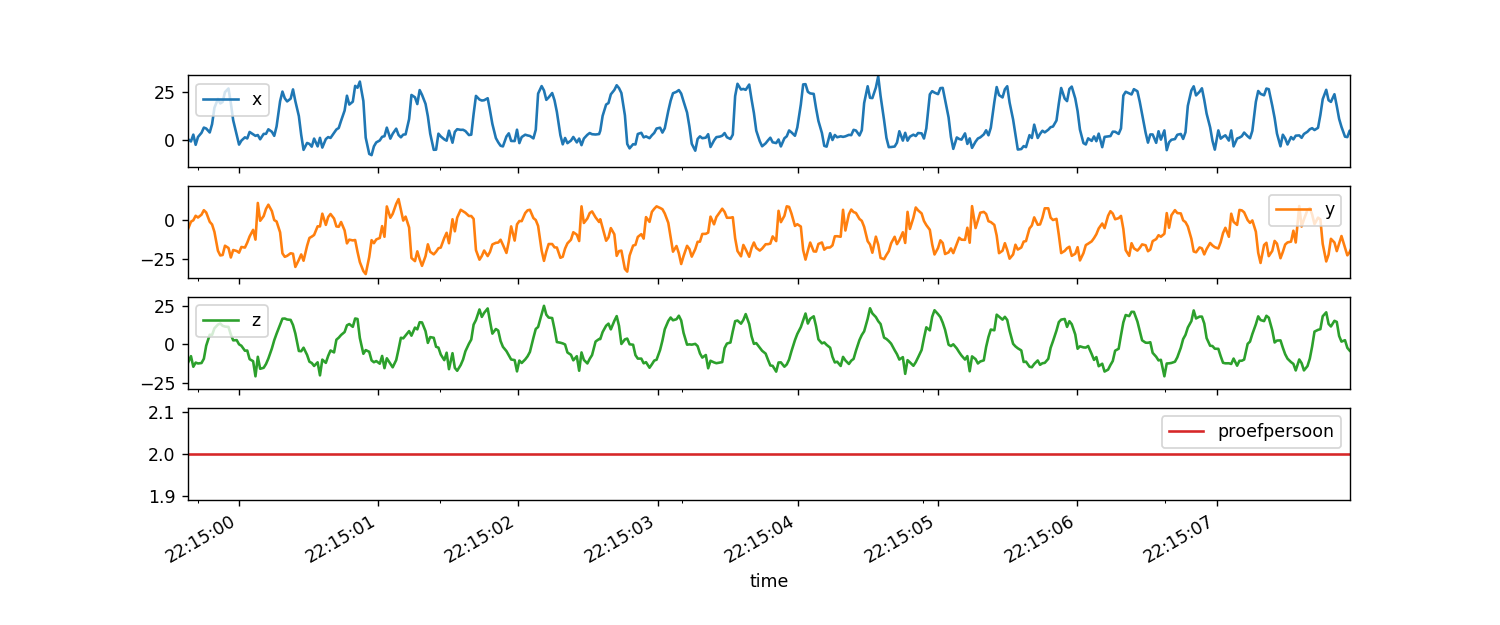

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000211AC58E3C8>,
      dtype=object)

In [29]:
jump_fast_right_forward3.plot(x='time', subplots=True)

In [42]:
for df in jump_fast_right_forward_2:
    f = sampling_freq(df)
    freq += f

#### jump_fast_left_backwards

In [43]:
jump_fast_left_backwards1 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast_backwards.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_left_backwards2 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast_left_backwards1.csv", sep=';', header=0, skipinitialspace=True)

jump_fast_left_backwards1 = preprocess(jump_fast_left_backwards1, "jump_fast","left_backwards", 2)
jump_fast_left_backwards2 = preprocess(jump_fast_left_backwards2, "jump_fast","left_backwards", 2)

jump_fast_left_backwards_2 = [jump_fast_left_backwards1, jump_fast_left_backwards2]

In [44]:
for df in jump_fast_left_backwards_2:
    f = sampling_freq(df)
    freq += f

#### jump_fast_right_backwards

In [45]:
jump_fast_right_backwards1 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast_right_backwards1.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_backwards2 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast_right_backwards2.csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right_backwards3 = pd.read_csv(r"..\data\jump_fast\proefpersoon2\jump_fast_right_backwards1(2).csv", sep=';', header=0, skipinitialspace=True)

jump_fast_right_backwards1 = preprocess(jump_fast_right_backwards1, "jump_fast","right_backwards", 2)
jump_fast_right_backwards2 = preprocess(jump_fast_right_backwards2, "jump_fast","right_backwards", 2)
jump_fast_right_backwards3 = preprocess(jump_fast_right_backwards3, "jump_fast","right_backwards", 2)

jump_fast_right_backwards_2 = [jump_fast_right_backwards1, jump_fast_right_backwards2, jump_fast_right_backwards3]

In [46]:
for df in jump_fast_right_backwards_2:
    f = sampling_freq(df)
    freq += f

### SEGMENTATION

In [47]:
if(not raw):
    #segmentation + feature extraction
    for i in range(0, len(jump_fast_left_forward_2)):
        jump_fast_left_forward_2[i] =  feature_extraction_segmentation(jump_fast_left_forward_2[i],1, True)

    for i in range(0, len(jump_fast_right_forward_2)):
        jump_fast_right_forward_2[i] =  feature_extraction_segmentation(jump_fast_right_forward_2[i],1, True)

    for i in range(0, len(jump_fast_left_backwards_2)):
        jump_fast_left_backwards_2[i] =  feature_extraction_segmentation(jump_fast_left_backwards_2[i],1, True)

    for i in range(0, len(jump_fast_right_backwards_2)):
        jump_fast_right_backwards_2[i] =  feature_extraction_segmentation(jump_fast_right_backwards_2[i],1, True)

In [48]:
jump_fast_right_backwards_2 = pd.concat(jump_fast_right_backwards_2, ignore_index=True)
jump_fast_right_backwards_2.shape

(5780, 7)

In [49]:
jump_fast_left_forward_2 = pd.concat(jump_fast_left_forward_2, ignore_index=True)
jump_fast_left_forward_2.shape

(5776, 7)

In [50]:
jump_fast_right_forward_2 = pd.concat(jump_fast_right_forward_2, ignore_index=True)
jump_fast_right_forward_2.shape

(6068, 7)

In [51]:
jump_fast_left_backwards_2 = pd.concat(jump_fast_left_backwards_2, ignore_index=True)
jump_fast_left_backwards_2.shape

(3349, 7)

### SHUFFLE - BALANCING

In [52]:
shape = np.min([
    jump_fast_right_backwards_2.shape[0], 
    jump_fast_left_forward_2.shape[0], 
    jump_fast_right_forward_2.shape[0], 
    jump_fast_left_backwards_2.shape[0]])

#### shuffle

In [53]:
''' 
jump_fast_right_backwards_2 = shuffle(jump_fast_right_backwards_2).head(shape).copy()
jump_fast_left_forward_2 = shuffle(jump_fast_left_forward_2).head(shape).copy()
jump_fast_right_forward_2 = shuffle(jump_fast_right_forward_2).head(shape).copy()
jump_fast_left_backwards_2 = shuffle(jump_fast_left_backwards_2).head(shape).copy()'''

' \njump_fast_right_backwards_2 = shuffle(jump_fast_right_backwards_2).head(shape).copy()\njump_fast_left_forward_2 = shuffle(jump_fast_left_forward_2).head(shape).copy()\njump_fast_right_forward_2 = shuffle(jump_fast_right_forward_2).head(shape).copy()\njump_fast_left_backwards_2 = shuffle(jump_fast_left_backwards_2).head(shape).copy()'

#### no shuffle

In [54]:
''' 
jump_fast_right_backwards_2 = jump_fast_right_backwards_2.head(shape).copy()
jump_fast_left_forward_2 = jump_fast_left_forward_2.head(shape).copy()
jump_fast_right_forward_2 = jump_fast_right_forward_2.head(shape).copy()
jump_fast_left_backwards_2 = jump_fast_left_backwards_2.head(shape).copy()'''

' \njump_fast_right_backwards_2 = jump_fast_right_backwards_2.head(shape).copy()\njump_fast_left_forward_2 = jump_fast_left_forward_2.head(shape).copy()\njump_fast_right_forward_2 = jump_fast_right_forward_2.head(shape).copy()\njump_fast_left_backwards_2 = jump_fast_left_backwards_2.head(shape).copy()'

# <font color='green'> Frequency

In [42]:
#mean
freq = freq/14
freq

88.8569491903626

# <font color='green'> Merging datasets

In [60]:
shape = np.min([
    jump_fast_1.shape[0],
    jump_fast_2.shape[0]
])

NameError: name 'jump_fast_1' is not defined

#### shuffle

In [ ]:
''' 
dataset = pd.concat([
    shuffle(jump_fast_1).head(shape),
    shuffle(jump_fast_2).head(shape)
])
dataset.shape'''

#### no shuffle

In [ ]:
''' 
dataset = pd.concat([
    jump_fast_1.head(shape),
    jump_fast_2.head(shape)
])
dataset.shape'''

In [43]:
jump_fast_right_backwards = pd.concat([
    jump_fast_right_backwards_2,
    jump_fast_right_backwards_1
])
jump_fast_left_backwards = pd.concat([
    jump_fast_left_backwards_2,
    jump_fast_right_backwards_1
])
jump_fast_right_forward = pd.concat([

    jump_fast_right_forward_2,
    jump_fast_right_backwards_1
])
jump_fast_left_forward = pd.concat([

    jump_fast_left_forward_2,
    jump_fast_right_backwards_1
])

In [56]:
jump_fast_right_backwards_1.to_csv("jump_fast_right_backwards_1.csv", sep=';')
jump_fast_left_backwards_1.to_csv("jump_fast_left_backwards_1.csv", sep=';')
jump_fast_right_forward_1.to_csv("jump_fast_right_forward_1.csv", sep=';')
jump_fast_left_forward_1.to_csv("jump_fast_left_forward_1.csv", sep=';')

In [57]:
jump_fast_right_backwards_2.to_csv("jump_fast_right_backwards_2.csv", sep=';')
jump_fast_left_backwards_2.to_csv("jump_fast_left_backwards_2.csv", sep=';')
jump_fast_right_forward_2.to_csv("jump_fast_right_forward_2.csv", sep=';')
jump_fast_left_forward_2.to_csv("jump_fast_left_forward_2.csv", sep=';')

In [ ]:
#dataset.to_csv("jump_fast_raw.csv", sep=';')